In [1]:
#from backtest import SimpleBacktest
import pandas as pd
import numpy as np
from xtquant import xtdata

In [3]:
# 移动平均线策略
def moving_average_strategy(data, short_window=20, long_window=50):
    if len(data) < long_window:
        return 0
    
    data = data.copy()
    data['short_ma'] = data['close'].rolling(window=short_window).mean()
    data['long_ma'] = data['close'].rolling(window=long_window).mean()
    
    current_short = data['short_ma'].iloc[-1]
    current_long = data['long_ma'].iloc[-1]
    prev_short = data['short_ma'].iloc[-2] if len(data) > 1 else current_short
    prev_long = data['long_ma'].iloc[-2] if len(data) > 1 else current_long
    
    # 金叉：买入信号
    if prev_short <= prev_long and current_short > current_long:
        return 1
    # 死叉：卖出信号
    elif prev_short >= prev_long and current_short < current_long:
        return -1
    else:
        return 0

# RSI策略
def rsi_strategy(data, period=14, oversold=30, overbought=70):
    if len(data) < period:
        return 0
    
    data = data.copy()
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    current_rsi = rsi.iloc[-1]
    
    if current_rsi < oversold:
        return 1  # 超卖，买入
    elif current_rsi > overbought:
        return -1  # 超买，卖出
    else:
        return 0

In [28]:
def generate_sample_data(days=2000, start_price=100):
    """生成示例价格数据"""
    dates = pd.date_range(start='2020-01-01', periods=days, freq='D')
    
    # 随机游走生成价格
    returns = np.random.normal(0.001, 0.02, days)
    prices = start_price * (1 + returns).cumprod()
    
    # 添加一些趋势和季节性
    trend = np.linspace(0, 0.2, days)
    seasonal = 0.1 * np.sin(2 * np.pi * np.arange(days) / 30)
    
    prices = prices * (1 + trend + seasonal)
    
    data = pd.DataFrame({
        'date': dates,
        'open': prices * (1 + np.random.normal(0, 0.01, days)),
        'high': prices * (1 + np.abs(np.random.normal(0, 0.015, days))),
        'low': prices * (1 - np.abs(np.random.normal(0, 0.015, days))),
        'close': prices,
        'volume': np.random.randint(1000000, 10000000, days)
    })
    
    return data

# 或者从文件加载真实数据
def load_data_from_csv(filepath):
    """从CSV文件加载数据"""
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').reset_index(drop=True)
    return data

=== 回测结果 ===
初始资金: 100,000.00
最终组合价值: 28,373.73
总收益率: -71.63%
年化收益率: -18.07%
夏普比率: -1.02
最大回撤: 73.45%
总交易次数: 28

=== 交易记录 ===
BUY | 2022-02-01 00:00:00 | 价格: 149.66 | 数量: 299.0
SELL | 2022-02-14 00:00:00 | 价格: 136.40 | 数量: 299.0
BUY | 2022-02-24 00:00:00 | 价格: 170.04 | 数量: 239.0
SELL | 2022-05-07 00:00:00 | 价格: 169.89 | 数量: 239.0
BUY | 2022-06-08 00:00:00 | 价格: 174.06 | 数量: 234.0
SELL | 2022-06-19 00:00:00 | 价格: 171.95 | 数量: 234.0
BUY | 2022-07-01 00:00:00 | 价格: 190.59 | 数量: 211.0
SELL | 2022-07-13 00:00:00 | 价格: 155.99 | 数量: 211.0
BUY | 2022-07-31 00:00:00 | 价格: 193.92 | 数量: 169.0
SELL | 2022-08-18 00:00:00 | 价格: 166.77 | 数量: 169.0


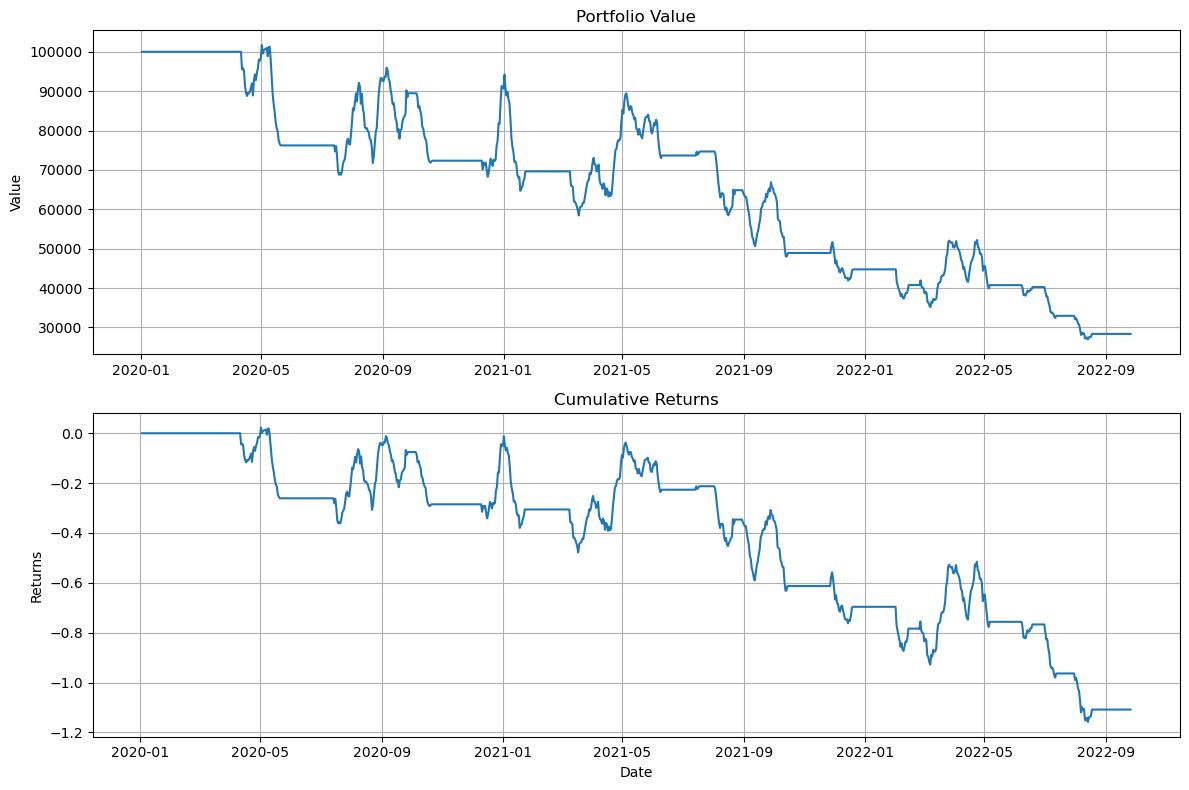

In [30]:
def main():
    # 生成示例数据
    data = generate_sample_data(1000)
    
    # 初始化回测引擎
    backtest = SimpleBacktest(initial_capital=100000)
    
    # 运行回测
    backtest.run_backtest(data, lambda x: moving_average_strategy(x, 20, 50))
    
    # 计算指标
    metrics = backtest.calculate_metrics()
    
    print("=== 回测结果 ===")
    print(f"初始资金: {backtest.initial_capital:,.2f}")
    print(f"最终组合价值: {backtest.portfolio_values[-1]:,.2f}")
    print(f"总收益率: {metrics['total_return']:.2%}")
    print(f"年化收益率: {metrics['annual_return']:.2%}")
    print(f"夏普比率: {metrics['sharpe_ratio']:.2f}")
    print(f"最大回撤: {metrics['max_drawdown']:.2%}")
    print(f"总交易次数: {metrics['total_trades']}")
    
    # 显示交易记录
    print("\n=== 交易记录 ===")
    for trade in backtest.trades[-10:]:  # 显示最后10笔交易
        print(f"{trade[0]} | {trade[1]} | 价格: {trade[2]:.2f} | 数量: {trade[3]}")
    
    # 绘制结果
    backtest.plot_results()

if __name__ == "__main__":
    main()

***** xtdata连接成功 *****
服务信息: {'tag': 'sp3', 'version': '1.0'}
服务地址: 127.0.0.1:58610
数据路径: D:\国金QMT交易端模拟\bin.x64/../userdata_mini/datadir
设置xtdata.enable_hello = False可隐藏此消息

成功获取 300 只沪深300成分股
前5只成分股示例: ['600000.SH', '600009.SH', '600010.SH', '600011.SH', '600015.SH']
获取到 300 只股票
生成股票数据...

正在测试第 1 只股票: 600000.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 2 只股票: 600009.SH
成功! 数据形状: (172, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 3 只股票: 600010.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 4 只股票: 600011.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 5 只股票: 600015.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 6 只股票: 600016.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 7 只股票: 600018.SH
成功! 数据形

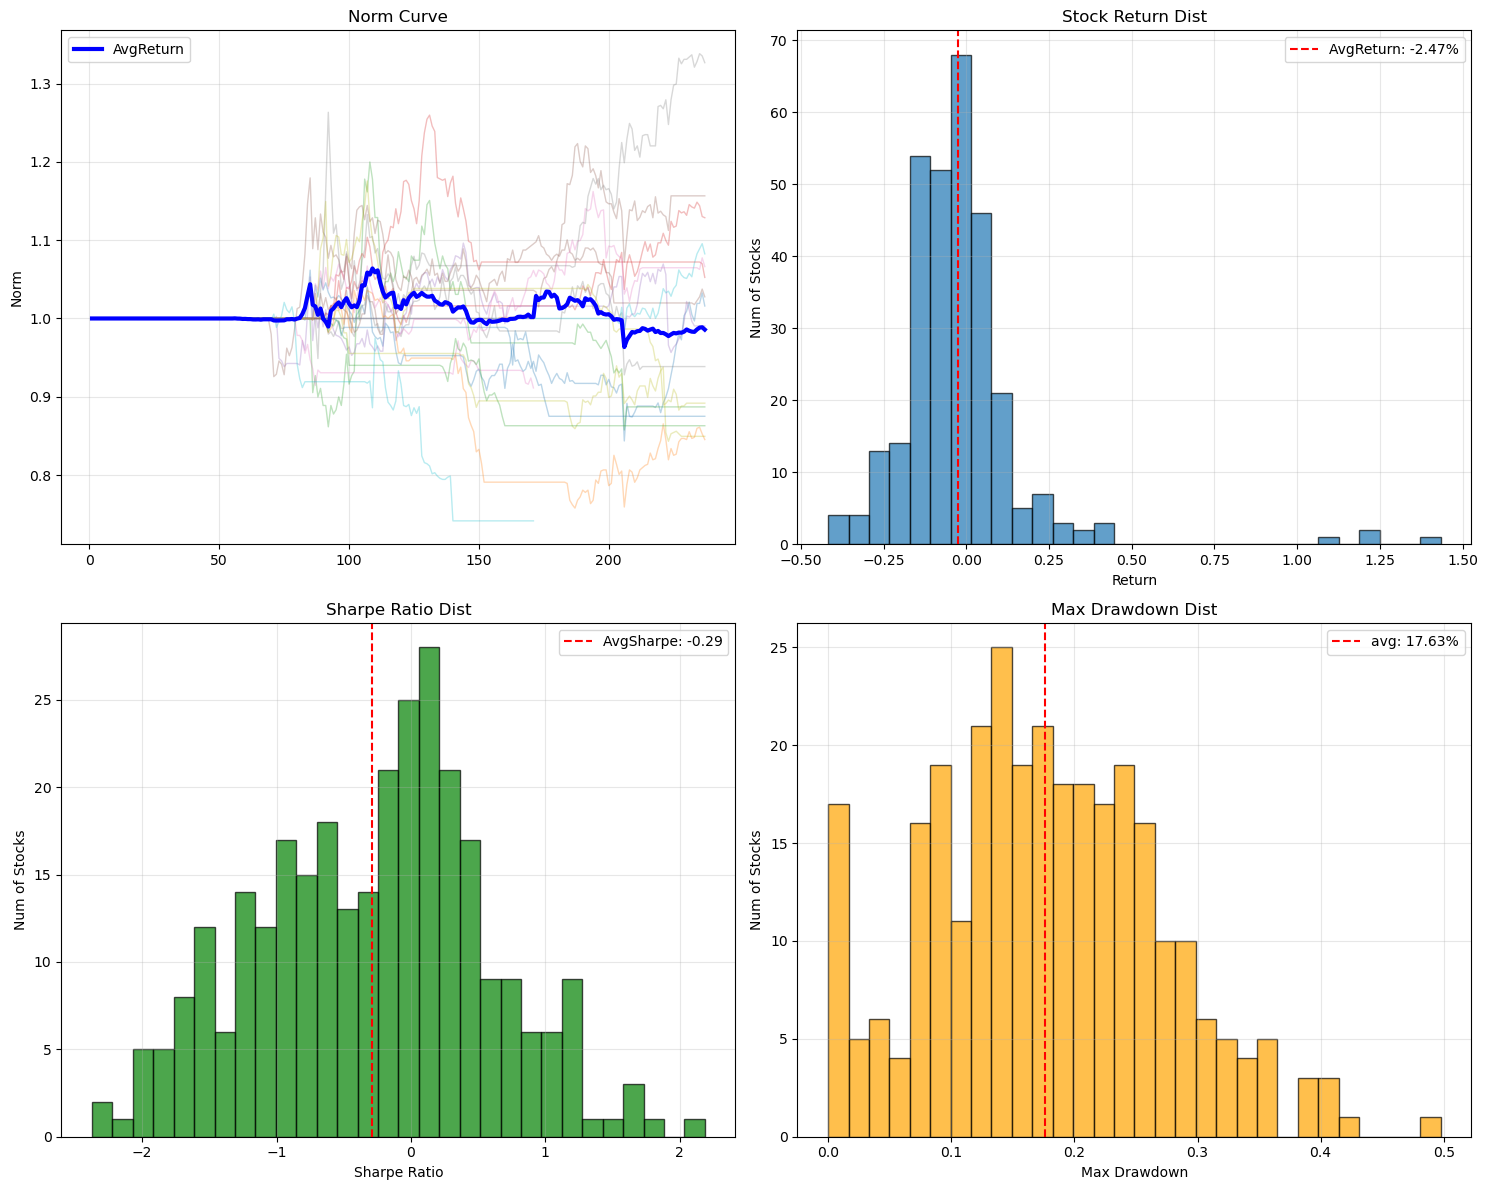

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xtquant import xtdata
import datetime
import dateutil

import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

class StockBacktest:
    def __init__(self, initial_capital=100000, commission=0.001, slippage=0.001):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.positions = 0
        self.trades = []
        self.portfolio_values = []
        self.dates = []
        self.commission = commission
        self.slippage = slippage
        self.position_price = 0
        self.current_stock = None
        
    def run_backtest(self, data, strategy_function, stock_code=None):
        """
        运行单只股票的回测
        data: 包含价格数据的DataFrame，必须有'close'列
        strategy_function: 策略函数
        stock_code: 股票代码，用于记录
        """
        self.current_stock = stock_code
        self.data = data.copy()
        self.capital = self.initial_capital
        self.positions = 0
        self.trades = []
        self.portfolio_values = []
        self.dates = []
        
        for i in range(1, len(data)):
            current_data = data.iloc[:i]
            current_price = data.iloc[i]['close']
            
            # 获取日期
            if 'date' in data.columns:
                current_date = data.iloc[i]['date']
            elif hasattr(data.index[i], 'strftime'):
                current_date = data.index[i]
            else:
                current_date = i
                
            # 获取交易信号
            signal = strategy_function(current_data)
            
            # 执行交易逻辑
            self.execute_trade(signal, current_price, current_date)
            
            # 记录组合价值
            portfolio_value = self.capital + self.positions * current_price
            self.portfolio_values.append(portfolio_value)
            self.dates.append(current_date)
            
        return self.calculate_metrics()
    
    def execute_trade(self, signal, price, date):
        """执行交易，考虑交易成本"""
        if signal == 1 and self.positions == 0:  # 买入信号，空仓
            # 考虑滑点和佣金
            execution_price = price * (1 + self.slippage)
            max_shares = self.capital // (execution_price * (1 + self.commission))
            
            if max_shares > 0:
                self.positions = max_shares
                cost = self.positions * execution_price * (1 + self.commission)
                self.capital -= cost
                self.position_price = execution_price
                self.trades.append({
                    'type': 'BUY', 
                    'date': date, 
                    'price': execution_price, 
                    'shares': self.positions,
                    'cost': cost,
                    'stock': self.current_stock
                })
            
        elif signal == -1 and self.positions > 0:  # 卖出信号，持仓
            execution_price = price * (1 - self.slippage)
            revenue = self.positions * execution_price * (1 - self.commission)
            self.capital += revenue
            
            # 计算这次交易的盈亏
            profit = revenue - (self.positions * self.position_price)
            
            self.trades.append({
                'type': 'SELL', 
                'date': date, 
                'price': execution_price, 
                'shares': self.positions,
                'revenue': revenue,
                'profit': profit,
                'stock': self.current_stock
            })
            self.positions = 0
            self.position_price = 0
    
    def calculate_metrics(self):
        """计算回测指标"""
        if len(self.portfolio_values) == 0:
            return {}
            
        returns = pd.Series(self.portfolio_values).pct_change().dropna()
        
        if len(returns) == 0:
            return {}
        
        total_return = (self.portfolio_values[-1] - self.initial_capital) / self.initial_capital
        trading_days = len(self.portfolio_values)
        
        # 年化收益率（考虑实际交易天数）
        annual_return = (1 + total_return) ** (252 / trading_days) - 1 if trading_days > 0 else 0
        
        # 夏普比率
        if returns.std() > 0:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
        else:
            sharpe_ratio = 0
            
        max_drawdown = self.calculate_max_drawdown()
        
        # 胜率计算
        winning_trades = len([t for t in self.trades if t.get('profit', 0) > 0])
        total_trades = len([t for t in self.trades if 'profit' in t])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        return {
            'stock_code': self.current_stock,
            'initial_capital': self.initial_capital,
            'final_value': self.portfolio_values[-1] if self.portfolio_values else self.initial_capital,
            'total_return': total_return,
            'annual_return': annual_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_trades': len(self.trades),
            'win_rate': win_rate,
            'avg_trade_profit': np.mean([t.get('profit', 0) for t in self.trades if 'profit' in t]) if total_trades > 0 else 0
        }
    
    def calculate_max_drawdown(self):
        """计算最大回撤"""
        if not self.portfolio_values:
            return 0
            
        peak = self.portfolio_values[0]
        max_dd = 0
        
        for value in self.portfolio_values:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > max_dd:
                max_dd = dd
                
        return max_dd

class PortfolioBacktest:
    def __init__(self, initial_capital=1000000):
        self.initial_capital = initial_capital
        self.stock_results = {}
        self.all_trades = []
        self.portfolio_values = {}
        
    def run_stock_universe_backtest(self, stock_data_dict, strategy_function, 
                                  start_date=None, end_date=None, 
                                  capital_per_stock=100000):
        """
        遍历股票池进行回测
        
        Parameters:
        stock_data_dict: 字典，键为股票代码，值为包含股票数据的DataFrame
        strategy_function: 策略函数
        start_date: 开始日期
        end_date: 结束日期
        capital_per_stock: 每只股票分配的资金
        """
        print(f"开始回测，股票数量: {len(stock_data_dict)}")
        print(f"时间范围: {start_date} 到 {end_date}")
        print(f"每只股票资金: {capital_per_stock:,}")
        print("=" * 60)
        
        total_stocks = len(stock_data_dict)
        completed = 0
        
        for stock_code, data in stock_data_dict.items():
            # 过滤时间范围
            if start_date and end_date:
                if 'date' in data.columns:
                    mask = (data['date'] >= start_date) & (data['date'] <= end_date)
                    filtered_data = data[mask].copy()
                else:
                    mask = (data.index >= start_date) & (data.index <= end_date)
                    filtered_data = data[mask].copy()
            else:
                filtered_data = data.copy()
            
            if len(filtered_data) < 50:  # 确保有足够的数据
                continue
                
            # 运行单只股票回测
            backtest = StockBacktest(initial_capital=capital_per_stock)
            metrics = backtest.run_backtest(filtered_data, strategy_function, stock_code)
            
            # 保存结果
            self.stock_results[stock_code] = metrics
            self.all_trades.extend(backtest.trades)
            
            # 保存组合价值序列（归一化以便比较）
            if backtest.portfolio_values:
                initial_value = backtest.portfolio_values[0] if backtest.portfolio_values else 1
                normalized_values = [v / initial_value for v in backtest.portfolio_values]
                self.portfolio_values[stock_code] = {
                    'dates': backtest.dates,
                    'values': normalized_values
                }
            
            completed += 1
            if completed % 10 == 0:
                print(f"进度: {completed}/{total_stocks}")
    
    def get_portfolio_metrics(self):
        """计算组合级别的回测指标"""
        if not self.stock_results:
            return {}
            
        # 组合总收益
        total_final_value = sum(result['final_value'] for result in self.stock_results.values())
        total_initial_value = sum(result['initial_capital'] for result in self.stock_results.values())
        portfolio_return = (total_final_value - total_initial_value) / total_initial_value
        
        # 平均指标
        avg_annual_return = np.mean([r['annual_return'] for r in self.stock_results.values()])
        avg_sharpe = np.mean([r['sharpe_ratio'] for r in self.stock_results.values()])
        avg_max_dd = np.mean([r['max_drawdown'] for r in self.stock_results.values()])
        avg_win_rate = np.mean([r['win_rate'] for r in self.stock_results.values()])
        
        # 正收益股票比例
        positive_returns = len([r for r in self.stock_results.values() if r['total_return'] > 0])
        positive_ratio = positive_returns / len(self.stock_results)
        
        return {
            'portfolio_total_return': portfolio_return,
            'avg_annual_return': avg_annual_return,
            'avg_sharpe_ratio': avg_sharpe,
            'avg_max_drawdown': avg_max_dd,
            'avg_win_rate': avg_win_rate,
            'positive_return_ratio': positive_ratio,
            'total_stocks_tested': len(self.stock_results),
            'total_trades': len(self.all_trades),
            'total_final_value': total_final_value
        }
    
    def print_detailed_report(self):
        """打印详细的组合回测报告"""
        portfolio_metrics = self.get_portfolio_metrics()
        
        print("=" * 70)
        print("PORTFOLIO BACKTEST REPORT - 沪深300股票池")
        print("=" * 70)
        print(f"测试股票数量: {portfolio_metrics['total_stocks_tested']}")
        print(f"总交易次数: {portfolio_metrics['total_trades']}")
        print(f"组合总收益率: {portfolio_metrics['portfolio_total_return']:.2%}")
        print(f"平均年化收益率: {portfolio_metrics['avg_annual_return']:.2%}")
        print(f"平均夏普比率: {portfolio_metrics['avg_sharpe_ratio']:.2f}")
        print(f"平均最大回撤: {portfolio_metrics['avg_max_drawdown']:.2%}")
        print(f"平均胜率: {portfolio_metrics['avg_win_rate']:.2%}")
        print(f"正收益股票比例: {portfolio_metrics['positive_return_ratio']:.2%}")
        print(f"最终组合价值: ${portfolio_metrics['total_final_value']:,.2f}")
        print("=" * 70)
        
        # 显示表现最好和最差的股票
        if self.stock_results:
            sorted_stocks = sorted(self.stock_results.items(), 
                                 key=lambda x: x[1]['total_return'], 
                                 reverse=True)
            
            print("\n表现最好的5只股票:")
            for stock, metrics in sorted_stocks[:5]:
                print(f"  {stock}: {metrics['total_return']:.2%} (交易次数: {metrics['total_trades']})")
            
            print("\n表现最差的5只股票:")
            for stock, metrics in sorted_stocks[-5:]:
                print(f"  {stock}: {metrics['total_return']:.2%} (交易次数: {metrics['total_trades']})")
    
    def plot_portfolio_performance(self):
        """绘制组合表现"""
        if not self.portfolio_values:
            print("没有足够的数据进行绘图")
            return
            
        plt.figure(figsize=(15, 12))
        
        # 1. 所有股票的归一化收益曲线
        plt.subplot(2, 2, 1)
        for stock_code, data in list(self.portfolio_values.items())[:20]:  # 只显示前20只股票
            if len(data['dates']) > 0:
                plt.plot(data['dates'], data['values'], alpha=0.3, linewidth=1)
        
        # 计算平均曲线
        all_dates = set()
        for data in self.portfolio_values.values():
            all_dates.update(data['dates'])
        
        if all_dates:
            sorted_dates = sorted(all_dates)
            avg_values = []
            for date in sorted_dates:
                day_values = []
                for data in self.portfolio_values.values():
                    if date in data['dates']:
                        idx = data['dates'].index(date)
                        day_values.append(data['values'][idx])
                if day_values:
                    avg_values.append(np.mean(day_values))
            
            if len(avg_values) == len(sorted_dates):
                plt.plot(sorted_dates, avg_values, 'b-', linewidth=3, label='AvgReturn')
        
        plt.title('Norm Curve')
        plt.ylabel('Norm')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. 收益率分布
        plt.subplot(2, 2, 2)
        returns = [metrics['total_return'] for metrics in self.stock_results.values()]
        plt.hist(returns, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(x=np.mean(returns), color='red', linestyle='--', label=f'AvgReturn: {np.mean(returns):.2%}')
        plt.title('Stock Return Dist')
        plt.xlabel('Return')
        plt.ylabel('Num of Stocks')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. 夏普比率分布
        plt.subplot(2, 2, 3)
        sharpes = [metrics['sharpe_ratio'] for metrics in self.stock_results.values()]
        plt.hist(sharpes, bins=30, alpha=0.7, edgecolor='black', color='green')
        plt.axvline(x=np.mean(sharpes), color='red', linestyle='--', label=f'AvgSharpe: {np.mean(sharpes):.2f}')
        plt.title('Sharpe Ratio Dist')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Num of Stocks')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. 最大回撤分布
        plt.subplot(2, 2, 4)
        drawdowns = [metrics['max_drawdown'] for metrics in self.stock_results.values()]
        plt.hist(drawdowns, bins=30, alpha=0.7, edgecolor='black', color='orange')
        plt.axvline(x=np.mean(drawdowns), color='red', linestyle='--', label=f'avg: {np.mean(drawdowns):.2%}')
        plt.title('Max Drawdown Dist')
        plt.xlabel('Max Drawdown')
        plt.ylabel('Num of Stocks')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 策略函数
def enhanced_ma_strategy(data, short_window=10, long_window=30):
    """增强的移动平均策略"""
    if len(data) < long_window:
        return 0
    
    df = data.copy()
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()
    
    current_short = df['short_ma'].iloc[-1]
    current_long = df['long_ma'].iloc[-1]
    
    # 需要前一个时间点的数据来判断金叉死叉
    if len(df) > 1:
        prev_short = df['short_ma'].iloc[-2]
        prev_long = df['long_ma'].iloc[-2]
    else:
        return 0
    
    # 金叉买入，死叉卖出
    if prev_short <= prev_long and current_short > current_long:
        return 1
    elif prev_short >= prev_long and current_short < current_long:
        return -1
    else:
        return 0

# 数据生成函数（模拟沪深300股票数据）
def generate_hs300_sample_data(stock_codes, start_date='20200101', end_date='20231231'):
    """生成沪深300股票的模拟数据"""
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    stock_data_dict = {}
    fields=['open', 'close', 'high', 'low', 'volume', 'amount', 'preClose']
    for i, code in enumerate(stock_codes):
        print(f"\n正在测试第 {i+1} 只股票: {code}")
        data = xtdata.get_market_data_ex(field_list=fields, stock_list=[code], 
                                         start_time=start_date, end_time=end_date, period='1d', 
                                         count=1000)

        if data and code in data:
            df = data[code]
            stock_data_dict[code] = df
            print(f"成功! 数据形状: {df.shape}, 列名: {df.columns.tolist()}")
        else:
            print("获取失败或数据格式异常") 
       
    
    return stock_data_dict

def get_hs300_stock_list():
    """
    获取沪深300成分股列表

    Returns:
        list: 包含沪深300成分股代码的列表，如果获取失败则返回空列表
    """
    try:
        # 获取沪深300成分股列表
        hs300_constituents = xtdata.get_stock_list_in_sector('沪深300')
        print(f"成功获取 {len(hs300_constituents)} 只沪深300成分股")
        print("前5只成分股示例:", hs300_constituents[:5])
        return hs300_constituents
    except Exception as e:
        print(f"获取沪深300成分股列表出错: {e}")
        return []  # 返回空列表而不是None，避免后续处理出错

# 主函数
def main():
    # 获取股票列表
    stock_codes = get_hs300_stock_list()
    print(f"获取到 {len(stock_codes)} 只股票")
    
    # 生成模拟数据
    print("生成股票数据...")
    stock_data_dict = generate_hs300_sample_data(
        stock_codes, 
        start_date='20230101', 
        end_date='20251231'
    )
    
    # 创建组合回测实例
    portfolio_backtest = PortfolioBacktest(initial_capital=1000000)
    
    # 运行组合回测
    print("开始组合回测...")
    portfolio_backtest.run_stock_universe_backtest(
        stock_data_dict=stock_data_dict,
        strategy_function=lambda x: enhanced_ma_strategy(x, 15, 50),
        start_date='20230101',
        end_date='20251231',
        capital_per_stock=20000  # 每只股票分配2万元
    )
    
    # 生成报告
    portfolio_backtest.print_detailed_report()
    
    # 绘制结果
    portfolio_backtest.plot_portfolio_performance()

if __name__ == "__main__":
    main()


🚀 开始高级策略回测比较
成功获取 300 只沪深300成分股
前5只成分股示例: ['600000.SH', '600009.SH', '600010.SH', '600011.SH', '600015.SH']
使用 5 只股票进行测试

正在测试第 1 只股票: 600000.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 2 只股票: 600009.SH
成功! 数据形状: (172, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 3 只股票: 600010.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 4 只股票: 600011.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']

正在测试第 5 只股票: 600015.SH
成功! 数据形状: (238, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']
多策略回测比较
策略数量: 7
股票数量: 5
时间范围: 20230101 到 20251231

正在运行策略: 双均线交叉
开始回测，股票数量: 5
时间范围: 20230101 到 20251231
每只股票资金: 20,000
双均线交叉 - 总收益: -1.73% | 年化收益: -2.94% | 夏普比率: -0.38

正在运行策略: RSI均值回归
开始回测，股票数量: 5
时间范围: 20230101 到 20251231
每只股票资金: 20,000
RSI均值回归 - 总收益: 11.16% | 年化收益: 11.59% | 夏普比率: 0.61

正在运行策略: 布林带突破
开始回测，股票数量:

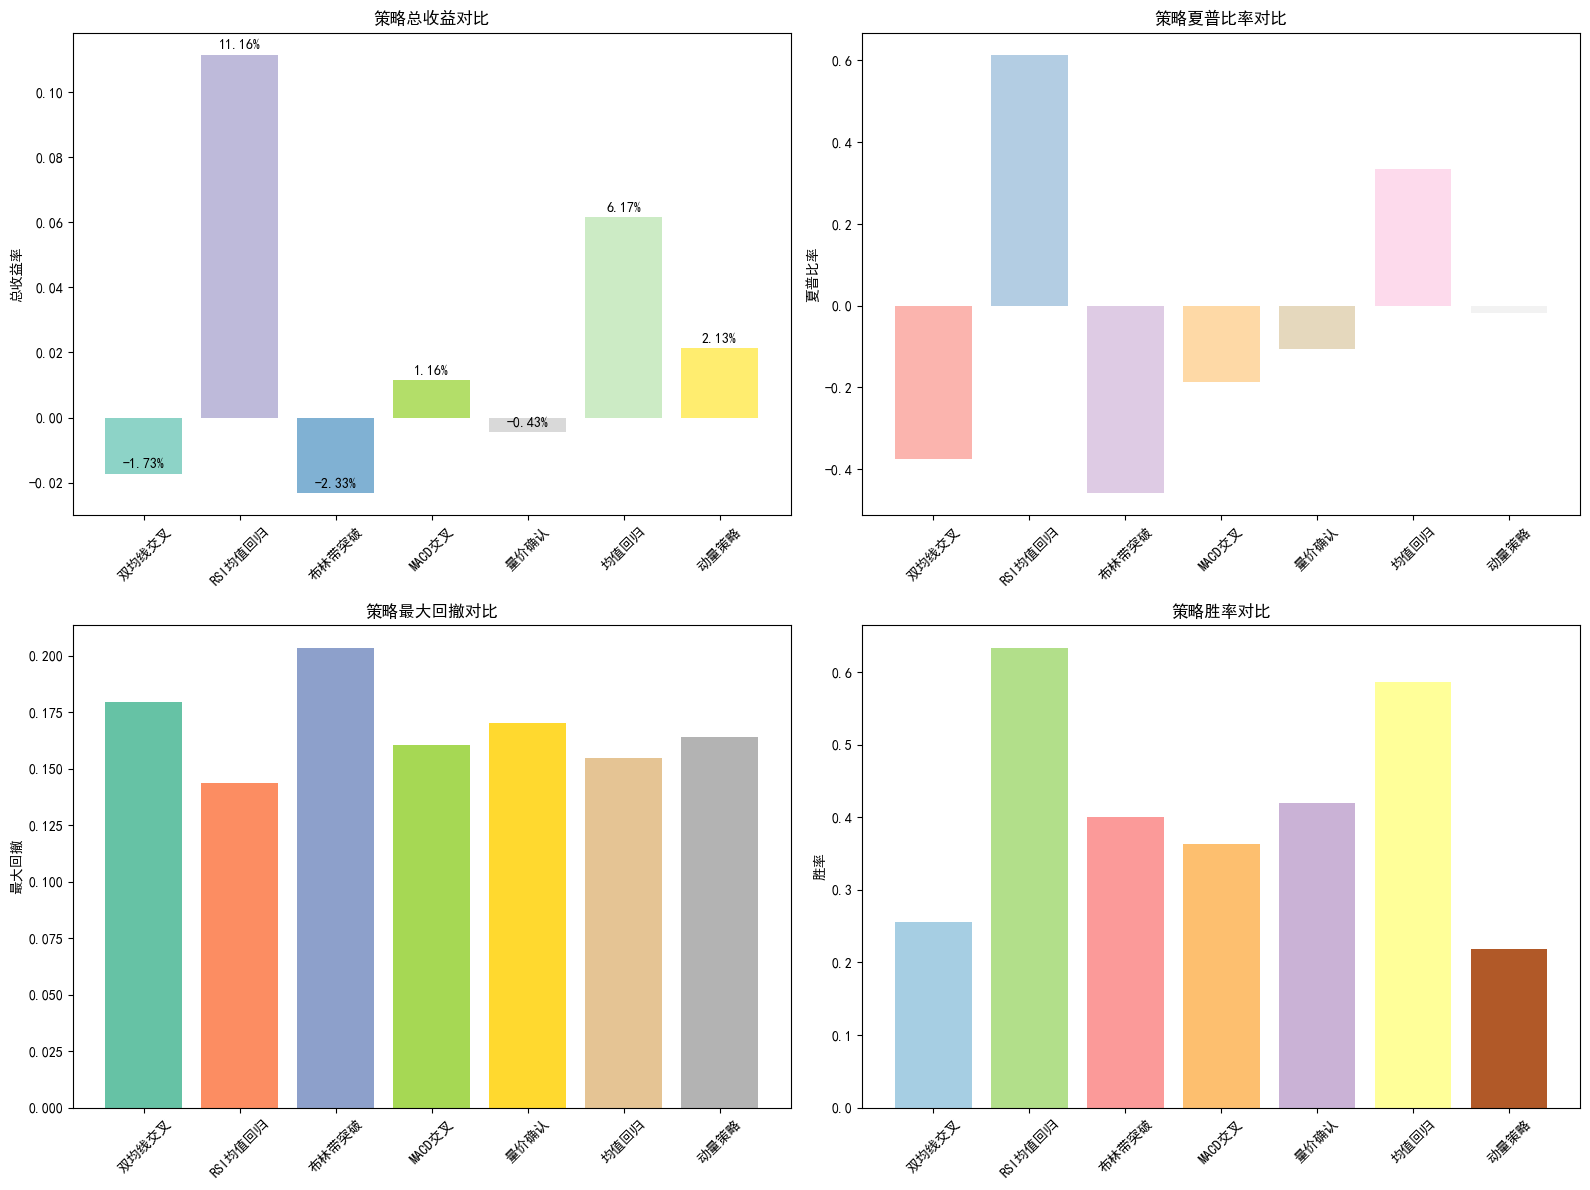


📊 最佳策略 'RSI均值回归' 的详细报告:
PORTFOLIO BACKTEST REPORT - 沪深300股票池
测试股票数量: 5
总交易次数: 29
组合总收益率: 11.16%
平均年化收益率: 11.59%
平均夏普比率: 0.61
平均最大回撤: 14.35%
平均胜率: 63.33%
正收益股票比例: 60.00%
最终组合价值: $111,159.18

表现最好的5只股票:
  600000.SH: 34.22% (交易次数: 8)
  600015.SH: 22.45% (交易次数: 7)
  600010.SH: 13.77% (交易次数: 6)
  600009.SH: -5.08% (交易次数: 4)
  600011.SH: -9.57% (交易次数: 4)

表现最差的5只股票:
  600000.SH: 34.22% (交易次数: 8)
  600015.SH: 22.45% (交易次数: 7)
  600010.SH: 13.77% (交易次数: 6)
  600009.SH: -5.08% (交易次数: 4)
  600011.SH: -9.57% (交易次数: 4)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xtquant import xtdata
import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

class AdvancedStrategies:
    """高级策略库"""
    
    @staticmethod
    def dual_moving_average_cross(data, short_window=5, long_window=20):
        """双均线交叉策略"""
        if len(data) < long_window:
            return 0
        
        df = data.copy()
        df['short_ma'] = df['close'].rolling(window=short_window).mean()
        df['long_ma'] = df['close'].rolling(window=long_window).mean()
        
        current_short = df['short_ma'].iloc[-1]
        current_long = df['long_ma'].iloc[-1]
        
        if len(df) > 1:
            prev_short = df['short_ma'].iloc[-2]
            prev_long = df['long_ma'].iloc[-2]
        else:
            return 0
        
        # 金叉买入，死叉卖出
        if prev_short <= prev_long and current_short > current_long:
            return 1
        elif prev_short >= prev_long and current_short < current_long:
            return -1
        else:
            return 0
    
    @staticmethod
    def rsi_mean_reversion(data, period=14, oversold=30, overbought=70):
        """RSI均值回归策略"""
        if len(data) < period + 1:
            return 0
        
        df = data.copy()
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        current_rsi = rsi.iloc[-1]
        
        if current_rsi < oversold:
            return 1  # 超卖，买入
        elif current_rsi > overbought:
            return -1  # 超买，卖出
        else:
            return 0
    
    @staticmethod
    def bollinger_breakout(data, period=20, num_std=2):
        """布林带突破策略"""
        if len(data) < period:
            return 0
        
        df = data.copy()
        df['middle_band'] = df['close'].rolling(window=period).mean()
        df['std'] = df['close'].rolling(window=period).std()
        df['upper_band'] = df['middle_band'] + (df['std'] * num_std)
        df['lower_band'] = df['middle_band'] - (df['std'] * num_std)
        
        current_close = df['close'].iloc[-1]
        current_upper = df['upper_band'].iloc[-1]
        current_lower = df['lower_band'].iloc[-1]
        prev_close = df['close'].iloc[-2] if len(df) > 1 else current_close
        
        # 上突破买入，下突破卖出
        if prev_close <= current_upper and current_close > current_upper:
            return 1
        elif prev_close >= current_lower and current_close < current_lower:
            return -1
        else:
            return 0
    
    @staticmethod
    def macd_crossover(data, fast_period=12, slow_period=26, signal_period=9):
        """MACD交叉策略"""
        if len(data) < slow_period + signal_period:
            return 0
        
        df = data.copy()
        exp1 = df['close'].ewm(span=fast_period, adjust=False).mean()
        exp2 = df['close'].ewm(span=slow_period, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        
        current_macd = macd.iloc[-1]
        current_signal = signal.iloc[-1]
        prev_macd = macd.iloc[-2] if len(macd) > 1 else current_macd
        prev_signal = signal.iloc[-2] if len(signal) > 1 else current_signal
        
        # MACD上穿信号线买入，下穿信号线卖出
        if prev_macd <= prev_signal and current_macd > current_signal:
            return 1
        elif prev_macd >= prev_signal and current_macd < current_signal:
            return -1
        else:
            return 0
    
    @staticmethod
    def volume_price_confirmation(data, volume_period=20):
        """量价确认策略"""
        if len(data) < volume_period:
            return 0
        
        df = data.copy()
        df['price_change'] = df['close'].pct_change()
        df['volume_ma'] = df['volume'].rolling(window=volume_period).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        current_price_change = df['price_change'].iloc[-1]
        current_volume_ratio = df['volume_ratio'].iloc[-1]
        prev_price_change = df['price_change'].iloc[-2] if len(df) > 1 else 0
        
        # 价涨量增买入，价跌量增卖出
        if current_price_change > 0 and current_volume_ratio > 1.2:
            return 1
        elif current_price_change < 0 and current_volume_ratio > 1.2:
            return -1
        else:
            return 0
    
    @staticmethod
    def mean_reversion(data, lookback=20, z_threshold=2):
        """均值回归策略（Z-score）"""
        if len(data) < lookback:
            return 0
        
        df = data.copy()
        returns = df['close'].pct_change().dropna()
        
        if len(returns) < lookback:
            return 0
        
        current_return = returns.iloc[-1]
        mean_return = returns.tail(lookback).mean()
        std_return = returns.tail(lookback).std()
        
        if std_return == 0:
            return 0
        
        z_score = (current_return - mean_return) / std_return
        
        # Z-score极端值回归
        if z_score < -z_threshold:
            return 1  # 超卖回归
        elif z_score > z_threshold:
            return -1  # 超买回归
        else:
            return 0
    
    @staticmethod
    def momentum_strategy(data, momentum_period=10, ma_period=20):
        """动量策略"""
        if len(data) < max(momentum_period, ma_period):
            return 0
        
        df = data.copy()
        df['momentum'] = df['close'] / df['close'].shift(momentum_period) - 1
        df['ma'] = df['close'].rolling(window=ma_period).mean()
        
        current_momentum = df['momentum'].iloc[-1]
        current_close = df['close'].iloc[-1]
        current_ma = df['ma'].iloc[-1]
        
        # 动量强劲且价格在均线上方买入
        if current_momentum > 0.02 and current_close > current_ma:
            return 1
        # 负动量且价格在均线下方卖出
        elif current_momentum < -0.02 and current_close < current_ma:
            return -1
        else:
            return 0

class MultiStrategyBacktest:
    """多策略回测框架"""
    
    def __init__(self, initial_capital=1000000):
        self.initial_capital = initial_capital
        self.strategy_results = {}
        self.comparison_results = {}
        
    def run_strategy_comparison(self, stock_data_dict, strategies_dict, 
                              start_date=None, end_date=None,
                              capital_per_stock=100000):
        """
        运行多策略比较回测
        
        Parameters:
        stock_data_dict: 股票数据字典
        strategies_dict: 策略字典，{策略名称: 策略函数}
        """
        print("=" * 80)
        print("多策略回测比较")
        print("=" * 80)
        print(f"策略数量: {len(strategies_dict)}")
        print(f"股票数量: {len(stock_data_dict)}")
        print(f"时间范围: {start_date} 到 {end_date}")
        print("=" * 80)
        
        for strategy_name, strategy_func in strategies_dict.items():
            print(f"\n正在运行策略: {strategy_name}")
            
            portfolio_backtest = PortfolioBacktest(initial_capital=self.initial_capital)
            portfolio_backtest.run_stock_universe_backtest(
                stock_data_dict=stock_data_dict,
                strategy_function=strategy_func,
                start_date=start_date,
                end_date=end_date,
                capital_per_stock=capital_per_stock
            )
            
            # 保存策略结果
            self.strategy_results[strategy_name] = portfolio_backtest
            self.comparison_results[strategy_name] = portfolio_backtest.get_portfolio_metrics()
            
            # 打印策略简要结果
            metrics = self.comparison_results[strategy_name]
            print(f"{strategy_name} - 总收益: {metrics['portfolio_total_return']:.2%} | "
                  f"年化收益: {metrics['avg_annual_return']:.2%} | "
                  f"夏普比率: {metrics['avg_sharpe_ratio']:.2f}")
    
    def print_strategy_comparison(self):
        """打印策略比较报告"""
        if not self.comparison_results:
            print("没有可比较的结果")
            return
        
        print("\n" + "=" * 100)
        print("多策略比较报告")
        print("=" * 100)
        
        # 创建比较表格
        comparison_df = pd.DataFrame(self.comparison_results).T
        comparison_df = comparison_df.sort_values('portfolio_total_return', ascending=False)
        
        # 选择关键指标显示
        key_metrics = [
            'portfolio_total_return', 'avg_annual_return', 'avg_sharpe_ratio',
            'avg_max_drawdown', 'avg_win_rate', 'positive_return_ratio', 'total_trades'
        ]
        
        display_df = comparison_df[key_metrics].copy()
        display_df.columns = ['总收益率', '年化收益率', '夏普比率', '平均最大回撤', 
                            '平均胜率', '正收益比例', '总交易次数']
        
        # 格式化显示
        formatted_df = display_df.copy()
        formatted_df['总收益率'] = formatted_df['总收益率'].apply(lambda x: f"{x:.2%}")
        formatted_df['年化收益率'] = formatted_df['年化收益率'].apply(lambda x: f"{x:.2%}")
        formatted_df['平均最大回撤'] = formatted_df['平均最大回撤'].apply(lambda x: f"{x:.2%}")
        formatted_df['平均胜率'] = formatted_df['平均胜率'].apply(lambda x: f"{x:.2%}")
        formatted_df['正收益比例'] = formatted_df['正收益比例'].apply(lambda x: f"{x:.2%}")
        formatted_df['夏普比率'] = formatted_df['夏普比率'].apply(lambda x: f"{x:.2f}")
        
        print(formatted_df.to_string())
        print("=" * 100)
        
        # 找出最佳策略
        best_strategy = comparison_df['portfolio_total_return'].idxmax()
        best_return = comparison_df.loc[best_strategy, 'portfolio_total_return']
        
        print(f"\n🎯 最佳策略: {best_strategy} (总收益: {best_return:.2%})")
        
        return comparison_df
    
    def plot_strategy_comparison(self):
        """绘制策略比较图"""
        if not self.strategy_results:
            print("没有策略结果可比较")
            return
        
        plt.figure(figsize=(16, 12))
        
        # 1. 策略收益对比
        plt.subplot(2, 2, 1)
        strategy_returns = {name: result.get_portfolio_metrics()['portfolio_total_return'] 
                          for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(strategy_returns)))
        bars = plt.bar(strategy_returns.keys(), strategy_returns.values(), color=colors)
        plt.title('策略总收益对比')
        plt.ylabel('总收益率')
        plt.xticks(rotation=45)
        
        # 在柱状图上添加数值
        for bar, value in zip(bars, strategy_returns.values()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.2%}', ha='center', va='bottom')
        
        # 2. 夏普比率对比
        plt.subplot(2, 2, 2)
        strategy_sharpes = {name: result.get_portfolio_metrics()['avg_sharpe_ratio'] 
                          for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(strategy_sharpes)))
        bars = plt.bar(strategy_sharpes.keys(), strategy_sharpes.values(), color=colors)
        plt.title('策略夏普比率对比')
        plt.ylabel('夏普比率')
        plt.xticks(rotation=45)
        
        # 3. 最大回撤对比
        plt.subplot(2, 2, 3)
        strategy_drawdowns = {name: result.get_portfolio_metrics()['avg_max_drawdown'] 
                            for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Set2(np.linspace(0, 1, len(strategy_drawdowns)))
        bars = plt.bar(strategy_drawdowns.keys(), strategy_drawdowns.values(), color=colors)
        plt.title('策略最大回撤对比')
        plt.ylabel('最大回撤')
        plt.xticks(rotation=45)
        
        # 4. 胜率对比
        plt.subplot(2, 2, 4)
        strategy_winrates = {name: result.get_portfolio_metrics()['avg_win_rate'] 
                           for name, result in self.strategy_results.items()}
        
        colors = plt.cm.Paired(np.linspace(0, 1, len(strategy_winrates)))
        bars = plt.bar(strategy_winrates.keys(), strategy_winrates.values(), color=colors)
        plt.title('策略胜率对比')
        plt.ylabel('胜率')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

# 原有的 StockBacktest 和 PortfolioBacktest 类保持不变
# 这里省略重复代码，只展示新增内容

def run_advanced_strategy_test():
    """运行高级策略测试"""
    print("🚀 开始高级策略回测比较")
    
    # 获取股票列表
    stock_codes = get_hs300_stock_list()[:5]  # 使用前20只股票进行快速测试
    print(f"使用 {len(stock_codes)} 只股票进行测试")
    
    # 获取数据
    stock_data_dict = generate_hs300_sample_data(
        stock_codes, 
        start_date='20230101', 
        end_date='20251231'
    )
    
    if not stock_data_dict:
        print("错误: 无法获取股票数据")
        return
    
    # 定义策略集合
    strategies = {
        "双均线交叉": lambda x: AdvancedStrategies.dual_moving_average_cross(x, 5, 20),
        "RSI均值回归": lambda x: AdvancedStrategies.rsi_mean_reversion(x, 14, 30, 70),
        "布林带突破": lambda x: AdvancedStrategies.bollinger_breakout(x, 20, 2),
        "MACD交叉": lambda x: AdvancedStrategies.macd_crossover(x, 12, 26, 9),
        "量价确认": lambda x: AdvancedStrategies.volume_price_confirmation(x, 20),
        "均值回归": lambda x: AdvancedStrategies.mean_reversion(x, 20, 2),
        "动量策略": lambda x: AdvancedStrategies.momentum_strategy(x, 10, 20)
    }
    
    # 运行多策略比较
    multi_backtest = MultiStrategyBacktest(initial_capital=500000)
    multi_backtest.run_strategy_comparison(
        stock_data_dict=stock_data_dict,
        strategies_dict=strategies,
        start_date='20230101',
        end_date='20251231',
        capital_per_stock=20000
    )
    
    # 生成比较报告
    comparison_df = multi_backtest.print_strategy_comparison()
    
    # 绘制比较图表
    multi_backtest.plot_strategy_comparison()
    
    # 显示最佳策略的详细报告
    best_strategy_name = comparison_df['portfolio_total_return'].idxmax()
    print(f"\n📊 最佳策略 '{best_strategy_name}' 的详细报告:")
    print("=" * 70)
    multi_backtest.strategy_results[best_strategy_name].print_detailed_report()
    
    return multi_backtest

# 主函数更新
def main():
    """主函数"""
    # 运行高级策略测试
    run_advanced_strategy_test()

if __name__ == "__main__":
    main()